In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ASNA-hackathon/sample_submission.csv
/kaggle/input/ASNA-hackathon/train.csv
/kaggle/input/ASNA-hackathon/test.csv


In [2]:
#Importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve, accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from statistics import mean
import matplotlib.pyplot as plt
import warnings
import math

In [3]:
df_train = pd.read_csv("/kaggle/input/ASNA-hackathon/train.csv") #7290
df_test = pd.read_csv("/kaggle/input/ASNA-hackathon/test.csv") #1844

In [4]:
df_train['Claim over 1k'].value_counts()

Claim over 1k
0    6458
1     832
Name: count, dtype: int64

In [5]:
for c in df_train.columns:
    if c != 'Effective To Date':
        col_type = df_train[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_train[c] = df_train[c].astype('category')

for c in df_test.columns:
    if c != 'Effective To Date':
        col_type = df_test[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_test[c] = df_test[c].astype('category')

In [6]:
cols_with_missing = [col for col in df_train.columns 
                                 if df_train[col].isnull().any()]                                  
candidate_train_predictors = df_train.drop(['CustomerID', 'Claim over 1k', 'Coverage', 'Education', 'Employment Status Index', 'Marital Status Index', 'Policy Type Index', 'Policy Index', 'Sales Channel Index', 'Vehicle Size'] + cols_with_missing, axis=1)
candidate_test_predictors = df_test.drop(['CustomerID', 'Coverage', 'Education', 'Employment Status Index', 'Marital Status Index', 'Policy Type Index', 'Policy Index', 'Sales Channel Index', 'Vehicle Size'] + cols_with_missing, axis=1)

In [7]:
candidate_train_predictors['Effective To Date'] = pd.to_datetime(candidate_train_predictors['Effective To Date'])
candidate_train_predictors['Current Date'] = '10/1/2024'
candidate_train_predictors['Current Date'] = pd.to_datetime(candidate_train_predictors['Current Date'])

# create new columns
candidate_train_predictors['clv_avg'] = candidate_train_predictors['Customer Lifetime Value'] / candidate_train_predictors['Months Since Policy Inception']
candidate_train_predictors['complaints_avg'] = candidate_train_predictors['Number of Open Complaints'] / candidate_train_predictors['Number of Policies']
candidate_train_predictors = candidate_train_predictors.drop(['Number of Open Complaints'], axis=1)
candidate_train_predictors['Policy Age (in months)'] = ((candidate_train_predictors['Current Date'] - candidate_train_predictors['Effective To Date']) / pd.Timedelta(days=30.44)).astype(int)
candidate_train_predictors = candidate_train_predictors.drop(['Current Date', 'Effective To Date'], axis=1)
# remove noise
candidate_train_predictors = candidate_train_predictors.drop(['State', 'Policy', 'Sales Channel', 'Renew Offer Type', 'Policy Type'], axis=1)

In [8]:
candidate_test_predictors['Effective To Date'] = pd.to_datetime(candidate_test_predictors['Effective To Date'])
candidate_test_predictors['Current Date'] = '10/1/2024'
candidate_test_predictors['Current Date'] = pd.to_datetime(candidate_test_predictors['Current Date'])

# create new columns
candidate_test_predictors['clv_avg'] = candidate_test_predictors['Customer Lifetime Value'] / candidate_test_predictors['Months Since Policy Inception']
candidate_test_predictors['complaints_avg'] = candidate_test_predictors['Number of Open Complaints'] / candidate_test_predictors['Number of Policies']
candidate_test_predictors = candidate_test_predictors.drop(['Number of Open Complaints'], axis=1)
candidate_test_predictors['Policy Age (in months)'] = ((candidate_test_predictors['Current Date'] - candidate_test_predictors['Effective To Date']) / pd.Timedelta(days=30.44)).astype(int)
candidate_test_predictors = candidate_test_predictors.drop(['Current Date', 'Effective To Date'], axis=1)
# remove noise
candidate_test_predictors = candidate_test_predictors.drop(['State', 'Policy', 'Sales Channel', 'Renew Offer Type', 'Policy Type'], axis=1)

In [9]:
candidate_train_predictors

,Customer Lifetime Value,Response,Coverage Index,Education Index,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,clv_avg,complaints_avg,Policy Age (in months)
0,3622.69,No,0,2,Employed,F,65163,Married,4,107,1,1,33.856916,3.0,9
1,10610.21,No,0,0,Unemployed,M,0,Single,26,14,7,1,757.872143,0.0,9
2,13868.02,No,1,1,Employed,M,81196,Single,11,38,3,1,364.947895,0.0,9
3,3119.69,No,0,2,Unemployed,F,0,Single,16,32,1,1,97.490313,0.0,9
4,5999.04,No,2,2,Employed,M,62618,Married,45,126,1,1,47.611429,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,27500.54,No,0,2,Unemployed,F,0,Single,0,28,2,1,982.162143,0.5,0
7286,11750.03,No,0,3,Employed,F,83561,Married,9,107,2,1,109.813364,0.0,0
7287,7757.04,No,0,2,Employed,F,69302,Married,23,119,9,1,65.185210,0.0,0
7288,3465.16,No,0,0,Employed,F,28856,Married,19,89,1,2,38.934382,0.0,0


# Modelliing

In [10]:
y = df_train['Claim over 1k']
X = candidate_train_predictors
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=314, stratify=y)

In [11]:
train_X

,Customer Lifetime Value,Response,Coverage Index,Education Index,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,clv_avg,complaints_avg,Policy Age (in months)
515,9556.58,No,1,1,Employed,M,31350,Married,14,89,4,2,107.377303,0.0,164
5639,9771.98,No,0,0,Unemployed,M,0,Married,42,73,2,1,133.862740,0.5,7
7049,15376.42,No,1,2,Employed,F,78552,Married,24,53,2,1,290.121132,0.0,1
6654,28166.82,No,0,1,Unemployed,F,0,Married,30,127,2,1,221.785984,0.0,3
3609,5625.58,No,0,1,Unemployed,M,0,Married,11,86,1,1,65.413721,0.0,163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5227,19408.34,No,2,1,Employed,M,94960,Married,15,58,3,1,334.626552,0.0,163
4624,3497.38,No,0,1,Employed,F,35074,Married,45,51,1,2,68.576078,0.0,163
3902,5701.02,No,0,2,Unemployed,M,0,Single,35,105,7,0,54.295429,0.0,163
3936,10108.46,No,0,1,Unemployed,F,0,Single,20,95,2,1,106.404842,0.0,163


In [12]:
lgbm = CatBoostClassifier(iterations=2,learning_rate=1,depth=2)
cat_features = [1,2,3,4,5,7]
lgbm.fit(train_X,train_y,cat_features=cat_features)
val_y_predlgbm = lgbm.predict(val_X)

fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
auc_pr = auc(recall, precision)

print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
print(f"PR-AUC of LightGBM on test set: {auc_pr}")

0:	learn: 0.3551845	total: 55.2ms	remaining: 55.2ms
1:	learn: 0.3071499	total: 57.4ms	remaining: 0us
Recall of LightGBM on test set: 0.12048192771084337
Precision of LightGBM on test set: 0.57
F1 score of LightGBM on test set: 0.86
ROC-AUC of LightGBM on test set: 0.5544360102950502
PR-AUC of LightGBM on test set: 0.39602383667533153


In [13]:
import catboost
from catboost.datasets import adult
from catboost.utils import eval_metric

In [14]:
train_X.columns

Index(['Customer Lifetime Value', 'Response', 'Coverage Index',
       'Education Index', 'Employment Status', 'Gender', 'Income',
       'Marital Status', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Policies',
       'Vehicle Size Index', 'clv_avg', 'complaints_avg',
       'Policy Age (in months)'],
      dtype='object')

In [15]:
df_test

,CustomerID,State,Customer Lifetime Value,Response,Coverage,Coverage Index,Education,Education Index,Effective To Date,Employment Status,...,Number of Policies,Policy Type,Policy Type Index,Policy,Policy Index,Renew Offer Type,Sales Channel,Sales Channel Index,Vehicle Size,Vehicle Size Index
0,WB38524,California,4008.95,No,Basic,0,High School or Below,0,1/1/2024,Employed,...,1,Personal Auto,0,Personal L3,2,2,Branch,1,Small,0
1,QP80741,Washington,8165.58,No,Basic,0,College,1,1/1/2024,Unemployed,...,2,Corporate Auto,1,Corporate L1,3,3,Agent,2,Medsize,1
2,WP41146,California,7210.94,No,Basic,0,High School or Below,0,1/1/2024,Unemployed,...,7,Personal Auto,0,Personal L2,1,1,Branch,1,Medsize,1
3,KR62797,Arizona,6198.70,No,Basic,0,High School or Below,0,1/1/2024,Employed,...,1,Personal Auto,0,Personal L2,1,2,Call Center,3,Medsize,1
4,VE55982,Nevada,3570.32,No,Basic,0,Bachelor,2,1/1/2024,Employed,...,1,Corporate Auto,1,Corporate L1,3,1,Call Center,3,Medsize,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,DK92504,Arizona,11851.77,No,Extended,1,High School or Below,0,9/2/2024,Employed,...,1,Corporate Auto,1,Corporate L1,3,3,Branch,1,Small,0
1840,YD28431,California,9438.68,No,Extended,1,Master,3,9/2/2024,Employed,...,4,Personal Auto,0,Personal L1,0,4,Agent,2,Large,2
1841,EZ43738,California,7026.27,No,Basic,0,Bachelor,2,9/2/2024,Medical Leave,...,6,Personal Auto,0,Personal L3,2,1,Agent,2,Medsize,1
1842,PJ36160,California,21968.20,No,Basic,0,Bachelor,2,9/2/2024,Employed,...,2,Personal Auto,0,Personal L2,1,3,Agent,2,Small,0


In [16]:
# from sklearn.model_selection import train_test_split
# from sklearn import datasets
# from catboost import CatBoostClassifier
# from sklearn.model_selection import GridSearchCV

# numeric_features = ['Customer Lifetime Value','Income','Months Since Last Claim','Months Since Policy Inception', 'Number of Policies','clv_avg', 'complaints_avg',
#        'Policy Age (in months)']
# categorical_features = ['Response', 'Coverage Index','Education Index', 'Employment Status', 'Gender','Vehicle Size Index','Marital Status']

# train_X, val_X, train_y, val_y = train_test_split(candidate_train_predictors, y, test_size=0.2, random_state=42)

# #Instantiate CatBoostClassifier
# cbc = CatBoostClassifier(verbose=False,scale_pos_weight=3)

# #create the grid
# grid = {'n_estimators':[200, 300, 400], 'min_child_samples': [1, 4, 8],'learning_rate': [0.01, 0.05]}

# #Instantiate GridSearchCV
# gscv = GridSearchCV (estimator = cbc, param_grid = grid, scoring ='accuracy', cv = 5)

# #fit the model
# gscv.fit(train_X,train_y, cat_features=cat_features)

# #returns the estimator with the best performance
# print(gscv.best_estimator_)

# #returns the best score
# print(gscv.best_score_)

# #returns the best parameters
# print(gscv.best_params_)

In [17]:
# 0.9314137641634368
# {'max_depth': 5, 'n_estimators': 200}

# 0.9326140093274011
# {'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 1, 'n_estimators': 300}

In [18]:
lgbm = CatBoostClassifier(n_estimators=300,max_depth=6, learning_rate=0.05, min_child_samples=1,verbose=False,scale_pos_weight=3.5)
cat_features = [1,2,3,4,5,7]
lgbm.fit(train_X,train_y,cat_features=cat_features)
val_y_predlgbm = lgbm.predict(val_X)

fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
auc_pr = auc(recall, precision)

print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
print(f"PR-AUC of LightGBM on test set: {auc_pr}")

Recall of LightGBM on test set: 0.6867469879518072
Precision of LightGBM on test set: 0.65
F1 score of LightGBM on test set: 0.92
ROC-AUC of LightGBM on test set: 0.8193796859263681
PR-AUC of LightGBM on test set: 0.6850697778018171


In [19]:
print(f"Confusion matrix\n {confusion_matrix(val_y, val_y_predlgbm)}\n")

Confusion matrix
 [[1230   62]
 [  52  114]]



In [20]:
# from yellowbrick.model_selection import LearningCurve
# from sklearn.model_selection import StratifiedKFold
# from yellowbrick.contrib.wrapper import wrap
# from yellowbrick.classifier import ROCAUC

# cv = StratifiedKFold(n_splits=10)
# sizes = np.linspace(0.1, 1.0, 10)
# catboost_model = CatBoostClassifier(n_estimators=300,max_depth=6, learning_rate=0.05, min_child_samples=1,verbose=False,scale_pos_weight=3.5)
# model = wrap(catboost_model)

# visualizer = ROCAUC(model)
# visualizer.fit(train_X, train_y)
# # visualizer.score(val_X, val_y)
# visualizer.show()

# # visualizer = LearningCurve(
# #     model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
# # )

# # visualizer.fit(train_X, train_y)        # Fit the data to the visualizer
# # visualizer.show()           # Finalize and render the figure

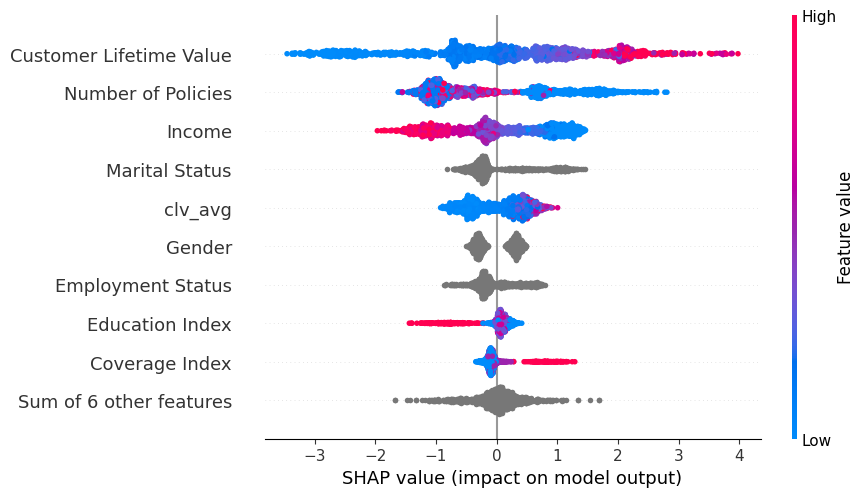

In [21]:
import shap
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer(val_X)
shap.plots.beeswarm(shap_values)
# shap.summary_plot(shap_values[1], val_X)
# shap.summary_plot(shap_values[1], val_X, max_display=15)

<Axes: >

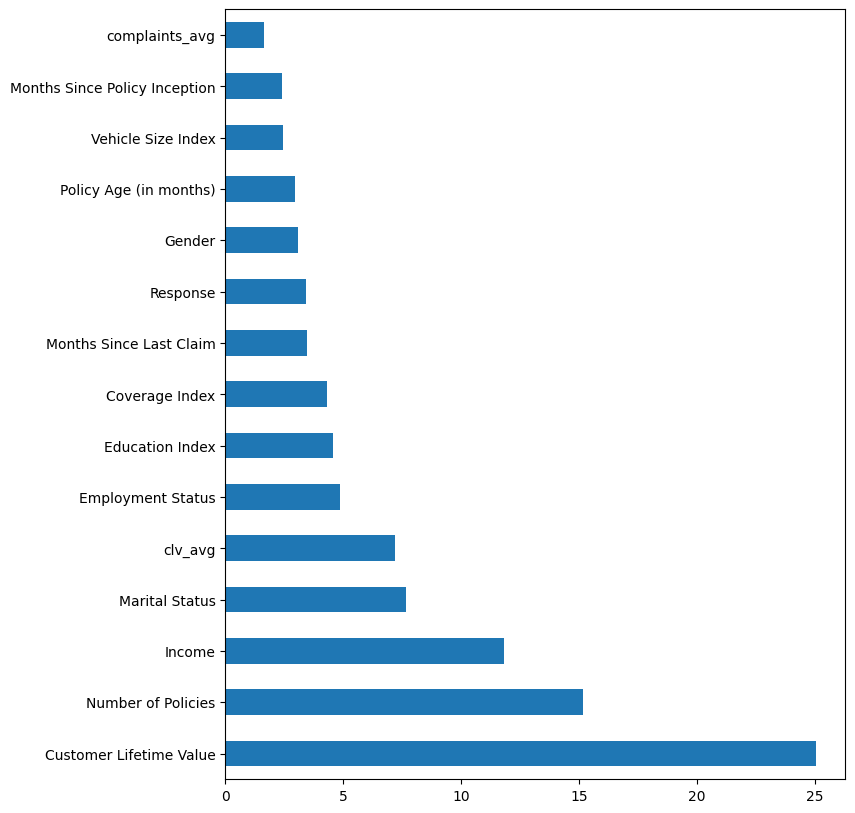

In [22]:
feat_imp = pd.Series(lgbm.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [23]:
print(f"Confusion matrix\n {confusion_matrix(val_y, val_y_predlgbm)}\n")

Confusion matrix
 [[1230   62]
 [  52  114]]



In [24]:
predictions = lgbm.predict(candidate_test_predictors)
output = pd.DataFrame({'CustomerID': df_test.CustomerID, 'Claim over 1k': predictions})
output.to_csv('submission.csv', index=False)